In [2]:
from functools import partial

import ceviche_challenges
from ceviche_challenges import units as u
from ceviche_challenges.model_base import _wavelengths_nm_to_omegas

from ceviche import viz, fdfd_ez
from ceviche import jacobian

import autograd
import autograd.numpy as npa
import jax
import jax.numpy as jnp

import numpy as np
import matplotlib.pyplot as plt

# Global flag to set a specific platform, must be used at startup.
jax.config.update('jax_platform_name', 'cpu')

In [4]:
from inverse_design.brushes import notched_square_brush, circular_brush
from inverse_design.conditional_generator import (
    new_latent_design, transform
)
from tqdm.notebook import trange

from javiche import jaxit

#from inverse_design.local_generator import generate_feasible_design_mask
from inverse_design.conditional_generator import generate_feasible_design_mask
from jax.example_libraries.optimizers import adam

# Define the problem using ceviche_challenges

In [5]:
spec = ceviche_challenges.waveguide_bend.prefabs.waveguide_bend_2umx2um_spec(
    wg_width=400*u.nm, variable_region_size=(1600*u.nm, 1600*u.nm), cladding_permittivity=2.25
)
params = ceviche_challenges.waveguide_bend.prefabs.waveguide_bend_sim_params(resolution = 25 * u.nm,
                                                                             wavelengths=u.Array([1270, 1290], u.nm))
model = ceviche_challenges.waveguide_bend.model.WaveguideBendModel(params, spec)

# Define the optimization function

In [6]:
def plot_state(model, rho, grads):
    des = forward(rho, brush)
    
    _, E_12 = model.simulate(des, excite_port_idxs=[0])
    _, E_21 = model.simulate(des, excite_port_idxs=[1])

    E_12 = E_12.squeeze()
    E_21 = E_21.squeeze()
    
    fig, ax = plt.subplots(1,5, figsize=(5*4,4))
    viz.abs(E_12, outline=model.density(des), ax=ax[0]);
    viz.abs(E_21, outline=model.density(des), ax=ax[1]);
    viz.real(grads, ax=ax[2]);
    ax[3].imshow(grads.T)
    #viz.real(ez_in * np.conj(ez_out), outline=model.density(np.asarray(design)), ax=ax[2]);
    #viz.real(ez_in * ez_out, outline=model.density(np.asarray(design)), ax=ax[3]);
    #viz.real((Ez_source.squeeze() * Ez_probe.squeeze()).T, outline=model.density(np.asarray(design)), ax=ax[4]);
    plt.show()

def db_to_au(x):
    return npa.power(10, x / 10)

S_cutoff_dB = npa.array([-20., -0.5])
S_cutoff = db_to_au(S_cutoff_dB)
g = npa.array([-1 if x < S_cutoff.max() else +1 for x in S_cutoff])
w_valid = npa.array([x if x < S_cutoff.max() else 1-x for x in S_cutoff])

min_w = jnp.min(w_valid)

def plot_state(model, rho, grads):
    des = forward(rho, brush)
    
    _, E_12 = model.simulate(des, excite_port_idxs=[0])
    _, E_21 = model.simulate(des, excite_port_idxs=[1])

    E_12 = E_12.squeeze()
    E_21 = E_21.squeeze()
    
    fig, ax = plt.subplots(1,5, figsize=(5*4,4))
    viz.abs(E_12, outline=model.density(des), ax=ax[0]);
    viz.abs(E_21, outline=model.density(des), ax=ax[1]);
    viz.real(grads, ax=ax[2]);
    ax[3].imshow(grads.T)
    #viz.real(ez_in * np.conj(ez_out), outline=model.density(np.asarray(design)), ax=ax[2]);
    #viz.real(ez_in * ez_out, outline=model.density(np.asarray(design)), ax=ax[3]);
    #viz.real((Ez_source.squeeze() * Ez_probe.squeeze()).T, outline=model.density(np.asarray(design)), ax=ax[4]);
    plt.show()

@jaxit()
def objective_S(rho):
    s_params, fields = model.simulate(rho)
    
    return s_params

@jaxit()
def inner_loss_mean(rho):
    s_params, fields = model.simulate(rho)
    s11 = npa.abs(s_params[:, 0, 0])
    s21 = npa.abs(s_params[:, 0, 1])
    
    return npa.mean(s11) - npa.mean(s21)

def loss_function(S):
    s11 = jnp.abs(S[:, 0, 0])**2
    s21 = jnp.abs(S[:, 0, 1])**2

    s = jnp.stack((s11,s21))
    g = jnp.stack((jnp.ones_like(s11),-jnp.ones_like(s21)))

    t_s21 = 10**(-0.5/10)
    t_s11 = 10**(-20/10)

    target = jnp.stack((jnp.ones_like(s11)*(t_s11**2),jnp.ones_like(s21)*(t_s21**2)))
    w_min = min(1-t_s21, t_s11)
    L = jnp.sum(jax.nn.softplus(g*(s-target)/w_min)**2)
    
    return L

In [7]:
@jaxit()
def objective_S(rho):
    s_params, fields = model.simulate(rho)
    
    return npa.abs(s_params)**2

@jaxit()
def inner_loss_mean(rho):
    s_params, fields = model.simulate(rho)
    s11 = npa.abs(s_params[:, 0, 0])
    s21 = npa.abs(s_params[:, 0, 1])
    
    return npa.mean(s11) - npa.mean(s21)

def loss_function(S):
    s11 = S[:, 0, 0]
    s21 = S[:, 0, 1]

    s = jnp.stack((s11,s21))
    g = jnp.stack((jnp.ones_like(s11),-jnp.ones_like(s21)))

    t_s21 = 10**(-0.5/10)
    t_s11 = 10**(-20/10)

    target = jnp.stack((jnp.ones_like(s11)*(t_s11**2),jnp.ones_like(s21)*(t_s21**2)))
    w_min = min(1-t_s21, t_s11)
    L = jnp.sum(jax.nn.softplus(g*(s-target)/w_min)**2)
    
    return L

# Then, the inverse design aka the conditional generator part

def forward(latent_weights, brush):
    latent_t = transform(latent_weights, brush) #.reshape((Nx, Ny))
    design_mask = generate_feasible_design_mask(latent_t, 
      brush, verbose=False)
    design = (design_mask+1.0)/2.0
    return design

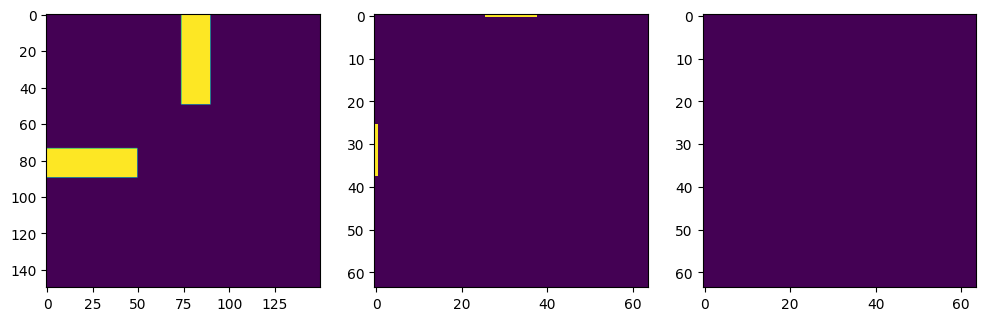

In [8]:
init_ts = np.zeros(model.design_region_shape, dtype=bool)
init_tv = np.zeros(model.design_region_shape, dtype=bool)

x0, y0, x1, y1 = model.design_region_coords

# Touch solid
#init_ts[0,:] = model.epsilon_r_bg()[x0-1, y0:y1] == model.epsilon_r_bg().max()
#init_ts[-1,:] = model.epsilon_r_bg()[x1+1, y0:y1] == model.epsilon_r_bg().max()
#init_ts[:,0] = model.epsilon_r_bg()[x0:x1, y0-1] == model.epsilon_r_bg().max()
#init_ts[:,-1] = model.epsilon_r_bg()[x0:x1, y1+1] == model.epsilon_r_bg().max()

#init_ts[0,2:-2] = model.epsilon_r_bg()[x0-1, y0+2:y1-2] == model.epsilon_r_bg().max()
#init_ts[2:-2,0] = model.epsilon_r_bg()[x0+2:x1-2,y0-1] == model.epsilon_r_bg().max()

HALF_BRUSH = 2
init_ts[24+HALF_BRUSH:-24-HALF_BRUSH,0] = model.epsilon_r_bg()[x0+24+HALF_BRUSH:x1-24-HALF_BRUSH,y0-1] == model.epsilon_r_bg().max()
init_ts[0,24+HALF_BRUSH:-24-HALF_BRUSH] = model.epsilon_r_bg()[x0-1,y0+24+HALF_BRUSH:y1-24-HALF_BRUSH,] == model.epsilon_r_bg().max()

# Touch void
#init_tv = np.logical_not(init_ts)
#init_tv[1:-1,1:-1] = False

fig, ax = plt.subplots(1,3, figsize=(4*3, 4))
ax[0].imshow(model.epsilon_r_bg());
ax[1].imshow(init_ts);
ax[2].imshow(init_tv);

In [9]:
np.sum(init_ts *1)

24

In [10]:
@jaxit()
def objective_S(rho):
    s_params, fields = model.simulate(rho)
    
    return s_params

@jaxit()
def inner_loss_mean(rho):
    s_params, fields = model.simulate(rho)
    s11 = npa.abs(s_params[:, 0, 0])
    s21 = npa.abs(s_params[:, 0, 1])
    
    return npa.mean(s11) - npa.mean(s21)

def loss_function(S):
    s11 = jnp.abs(S[:, 0, 0])**2
    s21 = jnp.abs(S[:, 0, 1])**2

    s = jnp.stack((s11,s21))
    g = jnp.stack((jnp.ones_like(s11),-jnp.ones_like(s21)))

    t_s21 = 10**(-0.5/20)
    t_s11 = 10**(-20/20)

    target = jnp.stack((jnp.ones_like(s11)*(t_s11**2),jnp.ones_like(s21)*(t_s21**2)))
    w_min = min(1-t_s21, t_s11)
    L = jnp.sum(jax.nn.softplus(g*(s-target)/w_min)**2)
    
    return L

In [11]:
mask2design = lambda x: (x+1.0)/2.0
def symmetrize(x):
    zero = x - jax.lax.stop_gradient(x)
    res_symm = (x + x.T) / 2
    return zero + res_symm

def inv_conv(x):
    zero = x - jax.lax.stop_gradient(x)
    res_conv = jax.lax.stop_gradient(jax.scipy.signal.convolve(x, brush * 1., mode='same'))
    return zero + res_conv

def forward_evolved(latent_weights, brush):
    latent_weights = symmetrize(latent_weights)
    #latent_weights = inv_conv(latent_weights)
    latent_t = transform(latent_weights, brush) #.reshape((Nx, Ny))
    #design_mask = generate_feasible_design_mask(latent_t, 
    #  brush, verbose=False)
    design_mask = generate_feasible_design_mask(latent_t, brush)
    #design_mask = symmetrize(design_mask)
    zero = design_mask - jax.lax.stop_gradient(design_mask)
    return zero + jax.lax.stop_gradient(mask2design(design_mask))

def forward(latent_weights, brush):
    latent_t = transform(latent_weights, brush, beta=2) #.reshape((Nx, Ny))
    design_mask = generate_feasible_design_mask(latent_t, 
      brush, verbose=False)
    design = (design_mask+1.0)/2.0
    return design

def forward_epured(latent_weights, brush):
    latent_t = transform(latent_weights, brush, beta=4)
    design_mask = generate_feasible_design_mask(latent_t, 
      brush, init_ts, init_tv, verbose=False)
    zero = design_mask - jax.lax.stop_gradient(design_mask)
    return zero + jax.lax.stop_gradient(mask2design(design_mask))

def forward_epured_no_t(latent_weights, brush):
    latent_weights = symmetrize(latent_weights) #Symmetrize
    latent_t = transform(latent_weights, brush, beta=4)
    design_mask = generate_feasible_design_mask(latent_t, 
      brush, verbose=False)
    zero = design_mask - jax.lax.stop_gradient(design_mask)
    return zero + jax.lax.stop_gradient(mask2design(design_mask))

def forward_no_gen(latent_weights, brush):
    zero = latent_weights - jax.lax.stop_gradient(latent_weights)
    return zero + jax.lax.stop_gradient(mask2design(latent_weights))

forward = forward_evolved

In [12]:
brush = circular_brush(5)
latent = new_latent_design(model.design_variable_shape, bias=1e-2, r=2, r_scale=1e-3)
#latent = new_latent_design(model.design_variable_shape, r=1)

/home/lucas/micromamba/envs/mamba_inverse_design/lib/python3.11/site-packages/inverse_design-0.0.0-py3.11.egg/inverse_design/conditional_generator.py:129: UserWarning: falling back on slower python-based feasible design generation!
  warnings.warn("falling back on slower python-based feasible design generation!")


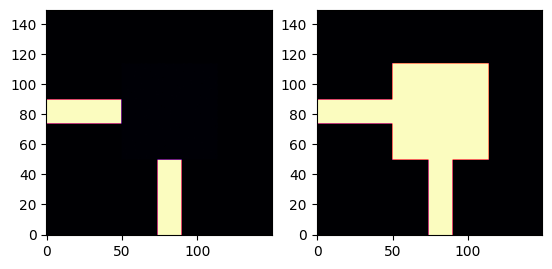

In [13]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(model.epsilon_r(latent), origin='lower', cmap='magma')
ax[1].imshow(model.epsilon_r(forward(latent, brush)), origin='lower', cmap='magma')

In [14]:
def loss_fn(latent):
    design = forward(latent, brush)
    S = objective_S(design)
    return loss_function(S)

def loss_mean(latent):
    design = forward(latent, brush)
    return inner_loss_mean(design)

def loss_no_gen(latent):
    S = objective_S(latent)
    return loss_function(S)

#loss_fn = loss_no_gen
#loss_fn = loss_mean

# Now we define the optimization

In [15]:
# Parameters for the Adam optimizer
step_size = 0.01
beta1 = 0.667
beta2 = 0.9

In [16]:
#latent = jnp.ones_like(latent) * 1e-3
#latent = new_latent_design(model.design_variable_shape, bias=1e-2, r=2, r_scale=1e-3)
latent = latent.at[:,0].set(0)
latent = latent.at[:,-1].set(0)
latent = latent.at[0,:].set(0)
latent = latent.at[-1,:].set(0)

In [17]:
grad_fn = jax.grad(loss_fn)

init_fn, update_fn, params_fn = adam(step_size)#, beta1, beta2)
state = init_fn(latent) #.flatten()
#value_and_grad seems to have a problem. Figure out why!

def step_fn(step, state, verbose=False):
    latent = params_fn(state) # we need autograd arrays here...
    grads = grad_fn(latent)
    loss = loss_fn(latent)

    optim_state = update_fn(step, grads, state)
    # optim_latent = params_fn(optim_state)
    # optim_latent = optim_latent/optim_latent.std()

    if verbose:
        plot_state(model, latent, grads)
        print("Step :", step+1, '/', Nsteps)
        print("Loss :", loss)
        print("Max grad:", np.max(grads))
    
    return loss, optim_state

In [18]:
# Number of epochs in the optimization
Nsteps = 5

init_fn, update_fn, params_fn = adam(step_size, beta1, beta2)
state = init_fn(npa.array(latent))

latent = params_fn(state)
grads = grad_fn(jnp.array(latent))

#|eval:false
VERBOSE = False

range_ = trange(Nsteps)
losses = np.ndarray(Nsteps)
beta = 2
for step in range_:
    #print(step)model.design_region
        
    loss, state = step_fn(step, state, VERBOSE)
    losses[step] = loss
    range_.set_postfix(loss=float(loss))
    
    if len(losses) > 6 and all(x > loss for x in losses[-3:]):
        beta += 1
    transform2 = partial(transform, beta=beta)

In [ ]:
#|eval:false

# Number of epochs in the optimization
Nsteps = 100

VERBOSE = False

range_ = trange(Nsteps)
losses = np.ndarray(Nsteps)
#beta = 6
for step in range_:
    #print(step)model.design_region
    loss, state = step_fn(step, state, VERBOSE)
    losses[step] = loss
    range_.set_postfix(loss=float(loss))

    #transform2 = partial(transform, beta=beta)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/lucas/micromamba/envs/mamba_inverse_design/lib/python3.11/site-packages/inverse_design-0.0.0-py3.11.egg/inverse_design/conditional_generator.py:129: UserWarning: falling back on slower python-based feasible design generation!
  warnings.warn("falling back on slower python-based feasible design generation!")


In [ ]:
plt.semilogy(np.arange(Nsteps), losses/np.max(losses));
plt.xlabel("Step")
plt.ylabel("Normalized loss")
plt.grid(True)

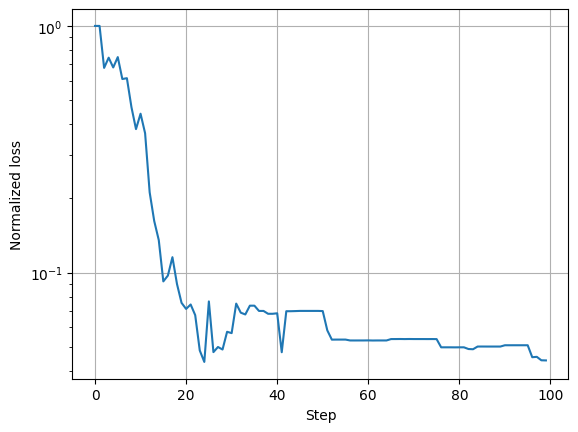

In [293]:
plt.semilogy(np.arange(Nsteps), losses/np.max(losses));
plt.xlabel("Step")
plt.ylabel("Normalized loss")
plt.grid(True)

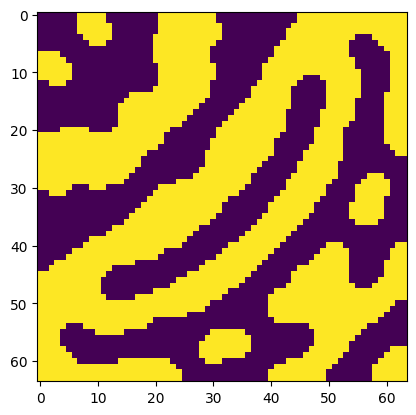

In [305]:
plt.imshow(forward(params_fn(state), brush))

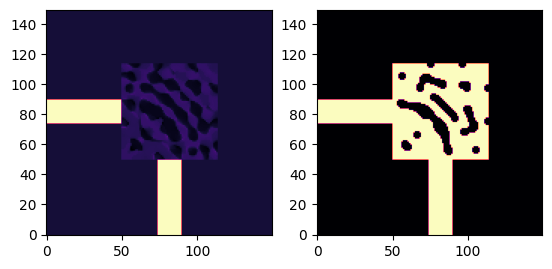

In [250]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(model.epsilon_r(params_fn(state)), origin='lower', cmap='magma')
ax[1].imshow(model.epsilon_r(forward(params_fn(state), brush)), origin='lower', cmap='magma')

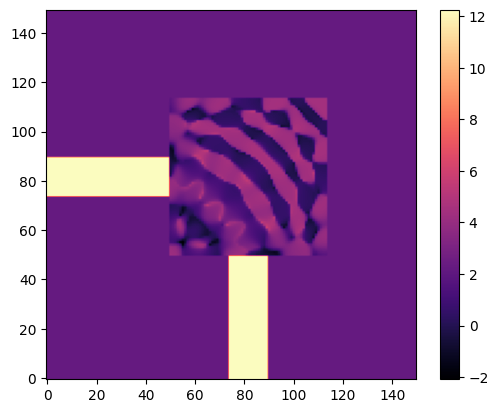

In [21]:
plt.imshow(model.epsilon_r(params_fn(state)), origin='lower', cmap='magma');
plt.colorbar();

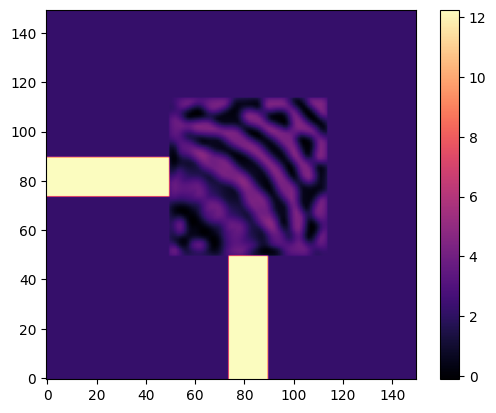

In [22]:
plt.imshow(model.epsilon_r(transform(params_fn(state), brush, 1)), origin='lower', cmap='magma');
plt.colorbar();